In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from google.cloud import bigquery
import db_dtypes
import scipy.stats as stats
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
os.environ[
    "GOOGLE_APPLICATION_CREDENTIALS"] = "the-webbing-454111-s0-9a04cc92eadc.json"  # lokalizacja pobranego klucza z punktu 1.4.
client = bigquery.Client()

In [3]:
query = """
SELECT DISTINCT
    country_name,
    iso_3166_1_alpha_3 AS `3 letter country code`,
    AVG(new_deceased) AS `new_deceased`,
    AVG(new_confirmed) AS `new_confirmed`,
    AVG(new_persons_vaccinated) AS `new_persons_vaccinated`,
    MAX(population) AS `population`, 
    MAX(gdp_usd) AS `GDP`, 
    MAX(health_expenditure_usd) AS `health_expenditure_usd`,
    AVG(population_density) AS `population density`,
    MAX(life_expectancy) AS `life_expectancy`, 
    CASE 
        WHEN SUM(new_confirmed) = 0 THEN 0 
        ELSE (SUM(new_deceased) * 100) / SUM(new_confirmed) 
    END AS `Deceased to Confirmed cases %`, 
    date,
FROM 
    `bigquery-public-data.covid19_open_data.covid19_open_data`
WHERE 
    aggregation_level = 0
GROUP BY 
    country_name, iso_3166_1_alpha_3, date
ORDER BY 
    country_name
"""
query_disease = client.query(query)
query_disease_result = query_disease.result()
disease_df = query_disease_result.to_dataframe()
#disease_df.dropna(inplace=True)
disease_df.to_csv('results\\prepared_for_3_ex.csv', index=False)


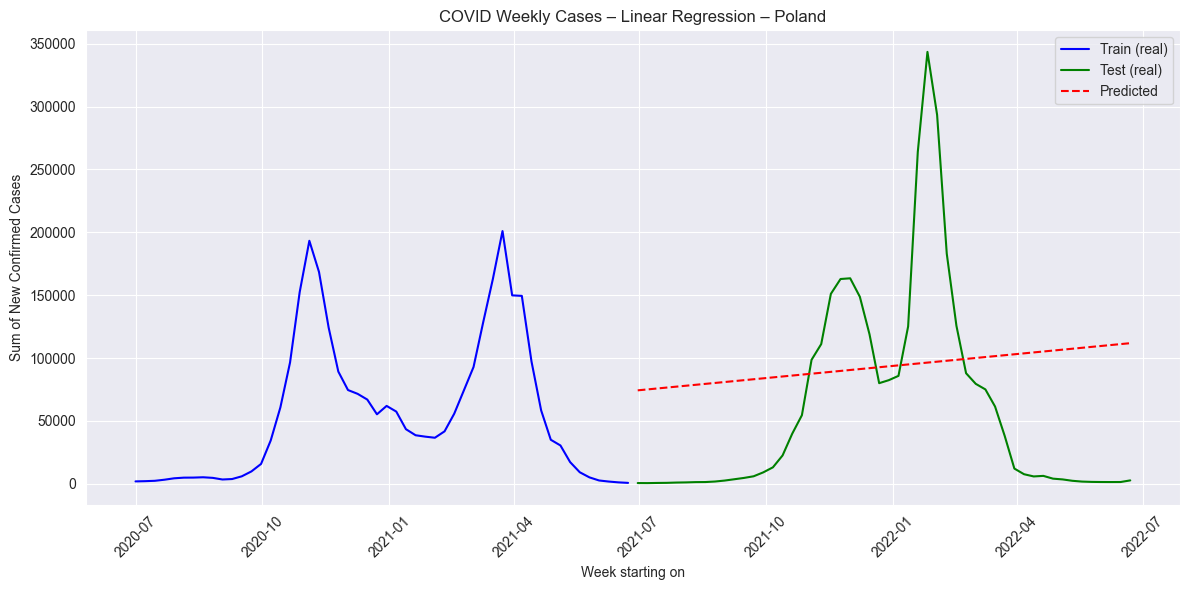

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Załaduj dane
df = pd.read_csv('results/prepared_for_3_ex.csv', parse_dates=['date'])

# Filtruj dla jednego kraju (np. Polska)
country = 'Poland'
df = df[df['country_name'] == country]

# Filtrowanie zakresu dat
df = df[(df['date'] >= '2020-07-01') & (df['date'] <= '2022-06-30')]

# Posortuj i dodaj numer tygodnia
df = df.sort_values('date')
df['week'] = ((df['date'] - df['date'].min()).dt.days // 7)

# Grupuj tygodniowo – i dodaj datę reprezentującą każdy tydzień (np. pierwszy dzień tygodnia)
weekly_df = df.groupby('week').agg({
    'new_confirmed': 'sum',
    'date': 'min'  # najwcześniejszy dzień w tygodniu jako reprezentant tygodnia
}).reset_index()

# Podział na dane treningowe i testowe
train_weeks = weekly_df[weekly_df['week'] <= 51]  # 52 tygodnie
test_weeks = weekly_df[(weekly_df['week'] > 51) & (weekly_df['week'] <= 103)]  # kolejne 52 tygodnie

# Dane do regresji
X_train = train_weeks[['week']]
y_train = train_weeks['new_confirmed']
X_test = test_weeks[['week']]
y_test = test_weeks['new_confirmed']

# Trening modelu
model = LinearRegression(n_jobs=-1)
model.fit(X_train, y_train)

# Predykcja
y_pred = model.predict(X_test)

# Wykres
plt.figure(figsize=(12, 6))
plt.plot(train_weeks['date'], y_train, label='Train (real)', color='blue')
plt.plot(test_weeks['date'], y_test, label='Test (real)', color='green')
plt.plot(test_weeks['date'], y_pred, label='Predicted', linestyle='--', color='red')
plt.xlabel('Week starting on')
plt.ylabel('Sum of New Confirmed Cases')
plt.title(f'COVID Weekly Cases – Linear Regression – {country}')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Jak widać, do takich zastosowań jak ilość nowych przypadków, regresja liniowa nie jest się odpowiednio dopasować - jest zrozumiałe bo jest to funkcja liniowa, a wiadomo, że nowe zachorowania nie będą się zachowywać w sposób liniowy.

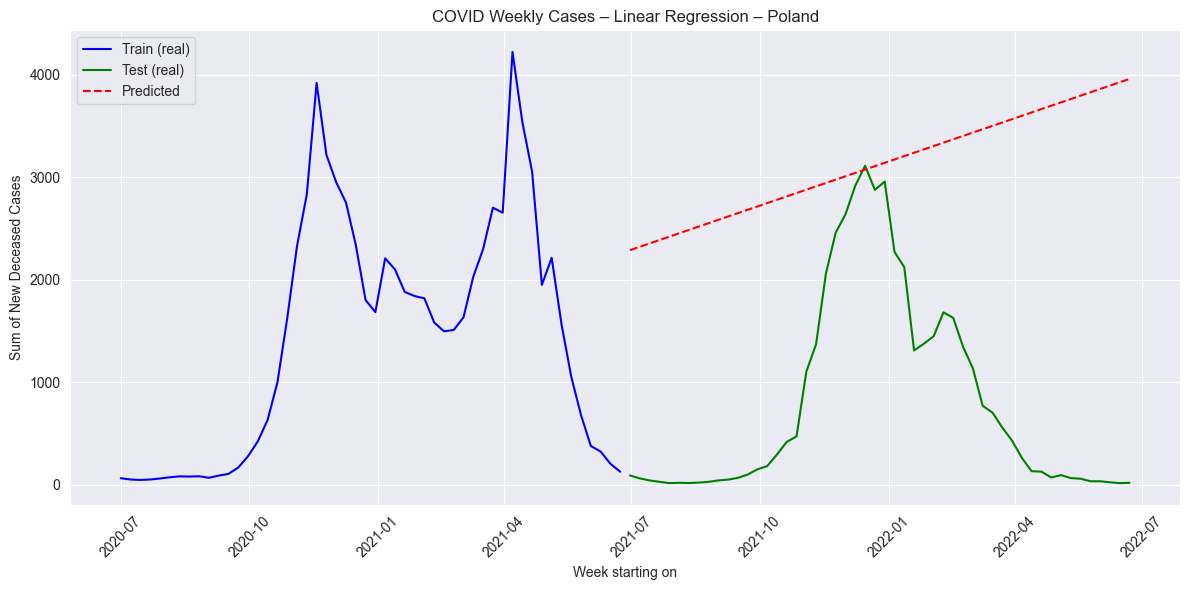

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Załaduj dane
df = pd.read_csv('results/prepared_for_3_ex.csv', parse_dates=['date'])

# Filtruj dla jednego kraju (np. Polska)
country = 'Poland'
df = df[df['country_name'] == country]

# Filtrowanie zakresu dat
df = df[(df['date'] >= '2020-07-01') & (df['date'] <= '2022-06-30')]

# Posortuj i dodaj numer tygodnia
df = df.sort_values('date')
df['week'] = ((df['date'] - df['date'].min()).dt.days // 7)

# Grupuj tygodniowo – i dodaj datę reprezentującą każdy tydzień (np. pierwszy dzień tygodnia)
weekly_df = df.groupby('week').agg({
    'new_deceased': 'sum',
    'date': 'min'  # najwcześniejszy dzień w tygodniu jako reprezentant tygodnia
}).reset_index()

# Podział na dane treningowe i testowe
train_weeks = weekly_df[weekly_df['week'] <= 51]  # 52 tygodnie
test_weeks = weekly_df[(weekly_df['week'] > 51) & (weekly_df['week'] <= 103)]  # kolejne 52 tygodnie

# Dane do regresji
X_train = train_weeks[['week']]
y_train = train_weeks['new_deceased']
X_test = test_weeks[['week']]
y_test = test_weeks['new_deceased']

# Trening modelu
model = LinearRegression(n_jobs=-1)
model.fit(X_train, y_train)

# Predykcja
y_pred = model.predict(X_test)

# Wykres
plt.figure(figsize=(12, 6))
plt.plot(train_weeks['date'], y_train, label='Train (real)', color='blue')
plt.plot(test_weeks['date'], y_test, label='Test (real)', color='green')
plt.plot(test_weeks['date'], y_pred, label='Predicted', linestyle='--', color='red')
plt.xlabel('Week starting on')
plt.ylabel('Sum of New Deceased Cases')
plt.title(f'COVID Weekly Cases – Linear Regression – {country}')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


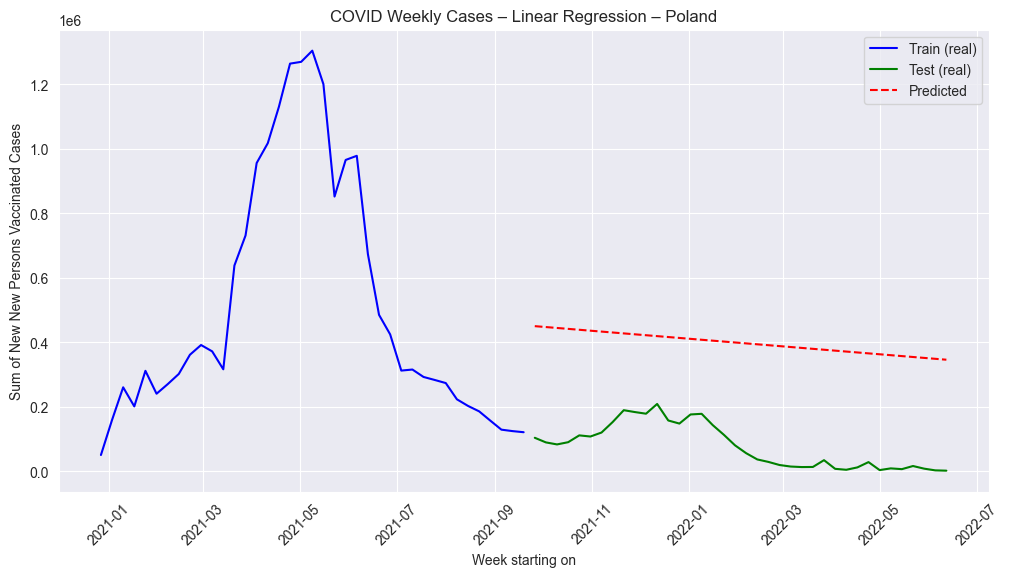

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Załaduj dane
df = pd.read_csv('results/prepared_for_3_ex.csv', parse_dates=['date'])

# Filtruj dla jednego kraju (np. Polska)
country = 'Poland'
df = df[df['country_name'] == country]

# Filtrowanie zakresu dat
df = df[(df['date'] >= '2020-12-27') & (df['date'] <= '2022-06-30')]

# Posortuj i dodaj numer tygodnia
df = df.sort_values('date')
df['week'] = ((df['date'] - df['date'].min()).dt.days // 7)

# Grupuj tygodniowo – i dodaj datę reprezentującą każdy tydzień (np. pierwszy dzień tygodnia)
weekly_df = df.groupby('week').agg({
    'new_persons_vaccinated': 'sum',
    'date': 'min'  # najwcześniejszy dzień w tygodniu jako reprezentant tygodnia
}).reset_index()

# Podział na dane treningowe i testowe
train_weeks = weekly_df[weekly_df['week'] <= 38]  # 52 tygodnie
test_weeks = weekly_df[(weekly_df['week'] > 38) & (weekly_df['week'] <= 76)]  # kolejne 52 tygodnie

# Dane do regresji
X_train = train_weeks[['week']]
y_train = train_weeks['new_persons_vaccinated']
X_test = test_weeks[['week']]
y_test = test_weeks['new_persons_vaccinated']

# Trening modelu
model = LinearRegression(n_jobs=-1)
model.fit(X_train, y_train)

# Predykcja
y_pred = model.predict(X_test)

# Wykres
plt.figure(figsize=(12, 6))
plt.plot(train_weeks['date'], y_train, label='Train (real)', color='blue')
plt.plot(test_weeks['date'], y_test, label='Test (real)', color='green')
plt.plot(test_weeks['date'], y_pred, label='Predicted', linestyle='--', color='red')
plt.xlabel('Week starting on')
plt.ylabel('Sum of New New Persons Vaccinated Cases')
plt.title(f'COVID Weekly Cases – Linear Regression – {country}')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()


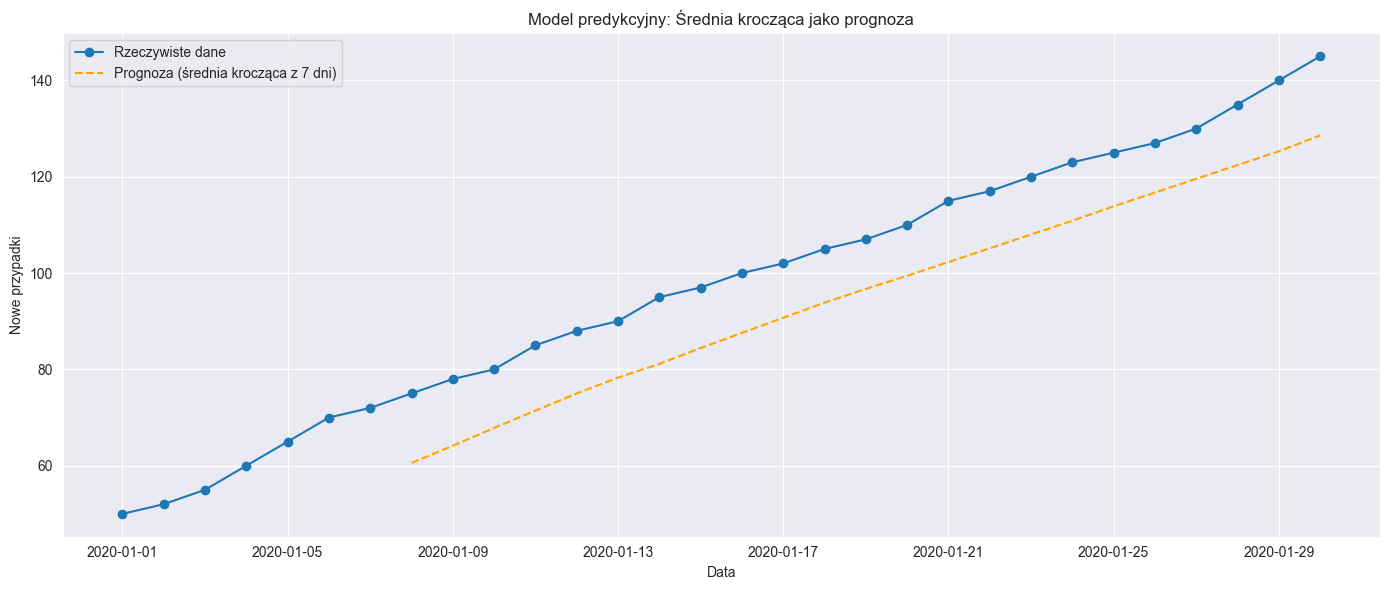